In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import os
import pathlib
from tensorflow_addons.layers import InstanceNormalization

In [2]:
PATH = './facades'

In [4]:
PATH = pathlib.Path(PATH)

In [5]:
list(PATH.iterdir())

[PosixPath('facades/test'),
 PosixPath('facades/train'),
 PosixPath('facades/val')]

In [6]:
sample_image = tf.io.read_file(str(PATH / 'train/1.jpg'))
sample_image = tf.io.decode_jpeg(sample_image)
print(sample_image.shape)

(256, 512, 3)


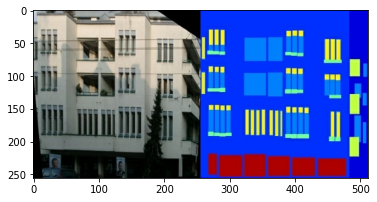

In [7]:
plt.figure()
plt.imshow(sample_image)

In [8]:
def load(image_file):
    
    # Read and decode an image file to a uint8 tensor
    image = tf.io.read_file(image_file)
    image = tf.io.decode_jpeg(image)
    
    # Split each image tensor into two tensors
    # - one with a real building facade image
    # - one with an architecture label image
    w = tf.shape(image)[1]
    w = w // 2
    input_image = image[:,w:,:]
    real_image = image[:,:w,:]
    
    # Convert both images to float32 tensors
    input_image = tf.cast(input_image, tf.float32)
    real_image = tf.cast(real_image, tf.float32)
    
    return input_image, real_image

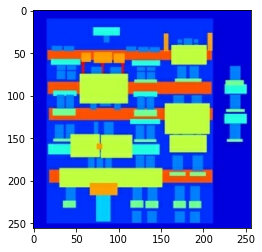

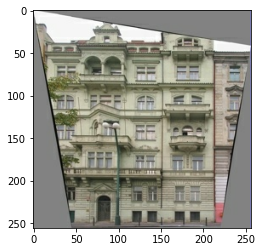

In [9]:
inp, re = load(str(PATH / 'train/100.jpg'))
# Casting to int for matplotlib to display the images
plt.figure()
plt.imshow(inp / 255.0)
plt.figure()
plt.imshow(re / 255.0)

In [10]:
# The facade training set consist of 400 images
BUFFER_SIZE = 400
# The batch size of 1 produced better results for the U-Net in the original pix2pix paper
BATCH_SIZE = 1
# Each image is 256x256 in size
image_shape = (256, 256, 3)
IMG_WIDTH = image_shape[0]
IMG_HEIGHT = image_shape[1]

In [11]:
def resize(input_image, real_image, height, width):
    input_image = tf.image.resize(input_image, [height, width],
                                  method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.resize(real_image, [height, width],
                                 method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return input_image, real_image

In [12]:
def random_crop(input_image, real_image):
    stacked_image = tf.stack([input_image, real_image], axis=0)
    cropped_image = tf.image.random_crop(stacked_image,
                                         size=[2, IMG_HEIGHT, IMG_WIDTH, 3])
    return cropped_image[0], cropped_image[1]

In [13]:
# Normalizing the image to [-1,1]
def normalize(input_image, real_image):
    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1
    
    return input_image, real_image

In [14]:
@tf.function
def random_jitter(input_image, real_image):
    # Resizing to 286x286
    input_image, real_image = resize(input_image, real_image, 286, 286)
    
    # Random cropping back to 256x256
    input_image, real_image = random_crop(input_image, real_image)
    
    if tf.random.uniform(()) > 0.5:
        # Random mirroring
        input_image = tf.image.flip_left_right(input_image)
        real_image = tf.image.flip_left_right(real_image)
        
    return input_image, real_image

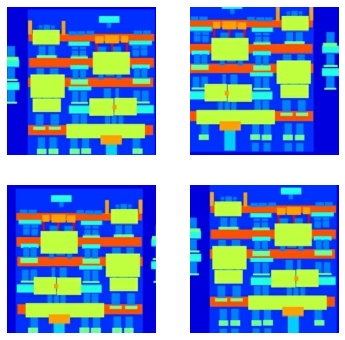

In [15]:
plt.figure(figsize=(6,6))
for i in range(4):
    rj_inp, rj_re = random_jitter(inp, re)
    plt.subplot(2,2,i+1)
    plt.imshow(rj_inp/255.0)
    plt.axis('off')
plt.show()

In [16]:
def load_image_train(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = random_jitter(input_image, real_image)
    input_image, real_image = normalize(input_image, real_image)
    
    return input_image, real_image

In [17]:
def load_image_test(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = resize(input_image, real_image, IMG_HEIGHT, IMG_WIDTH)
    input_image, real_image = normalize(input_image, real_image)
    
    return input_image, real_image

In [18]:
train_dataset = tf.data.Dataset.list_files(str(PATH / 'train/*.jpg'))
train_dataset = train_dataset.map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE).repeat()

In [19]:
try:
    test_dataset = tf.data.Dataset.list_files(str(PATH / 'test/*.jpg'))
except:
    test_dataset = tf.data.Dataset.list_files(str(PATH / 'val/*.jpg'))
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE).repeat()

In [23]:
class PIX2PIX():
    def __init__(self, input_shape):
        self.input_shape = input_shape
        
        # discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.trainable = False
        self.optimizer_discriminator = tf.keras.optimizers.Adam(2e-4, 0.5, 0.9999)
        
        # build generator pipeline with frozen discriminator
        self.generator = self.build_generator()
        discriminator_output = self.discriminator([self.generator.input,
                                                   self.generator.output])
        self.patch_size = discriminator_output.shape[1]
        self.model = tf.keras.Model(self.generator.input, [discriminator_output, self.generator.output])
        self.LAMBDA = 100
        self.bce = tf.keras.losses.BinaryCrossentropy()
        self.model.compile(loss = ['bce', 'mae'],
                           optimizer = tf.keras.optimizers.Adam(2e-4, 0.5, 0.9999),
                           loss_weights=[1, self.LAMBDA])
        self.discriminator.trainable = True
        
    def bce_loss(self, y_true, y_pred):
        loss = self.bce(y_true, y_pred)
        return loss
    
    def downsample(self, channels, kernels, strides=2, norm=True, activation=True, dropout=False):
        initializer = tf.random_normal_initializer(0.,0.02)
        block = tf.keras.Sequential()
        block.add(layers.Conv2D(channels, kernels, strides=strides, padding='same',
                                use_bias=False, kernel_initializer=initializer))
        if norm:
            block.add(InstanceNormalization())
        if activation:
            block.add(layers.LeakyReLU(0.2))
        if dropout:
            block.add(layers.Dropout(0.5))
            
        return block
    
    def upsample(self, channels, kernels, strides=1, norm=True, activation=True, dropout=False):
        initializer = tf.random_normal_initializer(0.,0.02)
        block = tf.keras.Sequential()
        block.add(layers.UpSampling2D((2,2)))
        block.add(layers.Conv2D(channels, kernels, strides=strides, padding='same',
                                use_bias=False, kernel_initializer=initializer))
        if norm:
            block.add(InstanceNormalization())
        if activation:
            block.add(layers.LeakyReLU(0.2))
        if dropout:
            block.add(layers.Dropout(0.5))
            
        return block
    
    def build_generator(self):
        
        DIM = 64
        
        input_image = layers.Input(shape=image_shape)
        down1 = self.downsample(DIM, 4, norm=False)(input_image) # 128, DIM
        down2 = self.downsample(2*DIM, 4)(down1) # 64, 2*DIM
        down3 = self.downsample(4*DIM, 4)(down2) # 32, 4*DIM
        down4 = self.downsample(4*DIM, 4)(down3) # 16, 4*DIM
        down5 = self.downsample(4*DIM, 4)(down4) # 8, 4*DIM
        down6 = self.downsample(4*DIM, 4)(down5) # 4, 4*DIM
        down7 = self.downsample(4*DIM, 4)(down6) # 2, 4*DIM
        
        up6 = self.upsample(4*DIM, 4, dropout=True)(down7) # 4, 4*DIM
        concat6 = layers.Concatenate()([up6, down6])
        
        up5 = self.upsample(4*DIM, 4, dropout=True)(concat6)
        concat5 = layers.Concatenate()([up5, down5])
        
        up4 = self.upsample(4*DIM, 4, dropout=True)(concat5)
        concat4 = layers.Concatenate()([up4, down4])
        
        up3 = self.upsample(4*DIM, 4)(concat4)
        concat3 = layers.Concatenate()([up3, down3])
        
        up2 = self.upsample(2*DIM, 4)(concat3)
        concat2 = layers.Concatenate()([up2, down2])
        
        up1 = self.upsample(DIM, 4)(concat2)
        concat1 = layers.Concatenate()([up1, down1])
        
        output_image = tf.keras.activations.tanh(self.upsample(3, 4, norm=False, activation=False)(concat1))
        
        return Model(input_image, output_image, name='generator')
    
    def build_discriminator(self):
        
        DIM = 64
        
        model = tf.keras.Sequential(name='discriminator')
        input_image_A = layers.Input(shape=image_shape)
        input_image_B = layers.Input(shape=image_shape)
        
        x = layers.Concatenate()([input_image_A, input_image_B])
        x = self.downsample(DIM, 4, norm=False)(x) # 128
        x = self.downsample(2*DIM, 4)(x) # 64
        x = self.downsample(4*DIM, 4)(x) # 32
        x = self.downsample(8*DIM, 4, strides=1)(x) # 29
        output = layers.Conv2D(1, 4, activation='sigmoid')(x)
        
        return Model([input_image_A, input_image_B], output)
    
    def train_discriminator(self, real_images_A, real_images_B, batch_size):
        real_labels = tf.ones((batch_size, self.patch_size, self.patch_size, 1))
        fake_labels = tf.zeros((batch_size, self.patch_size, self.patch_size, 1))
        
        fake_images_B = self.generator.predict(real_images_A)
        
        with tf.GradientTape() as gradient_tape:
            
            # forward pass
            pred_fake = self.discriminator([real_images_A, fake_images_B])
            pred_real = self.discriminator([real_images_A, real_images_B])
            
            # calculate losses
            loss_fake = self.bce_loss(fake_labels, pred_fake)
            loss_real = self.bce_loss(real_labels, pred_real)
            
            # total loss
            total_loss = 0.5*(loss_fake+loss_real)
            
            # apply gradients
            gradients = gradient_tape.gradient(total_loss, self.discriminator.trainable_variables)
            
            self.optimizer_discriminator.apply_gradients(zip(gradients, self.discriminator.trainable_variables))
            
        return loss_fake, loss_real
    
    def train(self, data_generator, test_data_generator, batch_size, steps, interval=100):
        val_images = next(test_data_generator)
        real_labels = tf.ones((batch_size, self.patch_size, self.patch_size, 1))
        self.batch_size = batch_size
        
        for i in range(steps):
            real_images_A, real_images_B = next(data_generator)
            loss_fake, loss_real = self.train_discriminator(real_images_A, real_images_B, batch_size)
            discriminator_loss = 0.5*(loss_fake+loss_real)
            
            # train generator
            g_loss =self.model.train_on_batch(real_images_A, [real_labels, real_images_B])
            if i%interval == 0:
                msg = 'Step {}: discriminator_loss {:.4f} g_loss {:.4f}'\
                .format(i, discriminator_loss, g_loss[0])
                print(msg)
                
                fake_images = self.generator.predict(val_images[0])
                self.plot_images(val_images, fake_images)
                
    def plot_images(self, real_images, fake_images):
        grid_row = min(fake_images.shape[0], 4)
        grid_col = 3
        f, axarr = plt.subplots(grid_row, grid_col, figsize=(grid_col*6, grid_row*6))
        for row in range(grid_row):
            ax = axarr if grid_row==1 else axarr[row]
            ax[0].imshow((real_images[0][row]+1)/2)
            ax[0].axis('off')
            ax[1].imshow((real_images[1][row]+1)/2)
            ax[1].axis('off')
            ax[2].imshow((fake_images[row]+1)/2)
            ax[2].axis('off')
        plt.show()

In [24]:
pix2pix = PIX2PIX(image_shape)

Step 0: discriminator_loss 0.6797 g_loss 25.3502


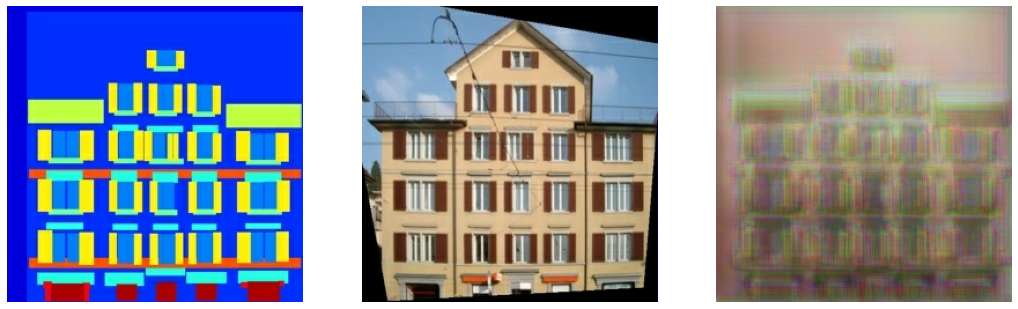

Step 10: discriminator_loss 0.7270 g_loss 32.8825


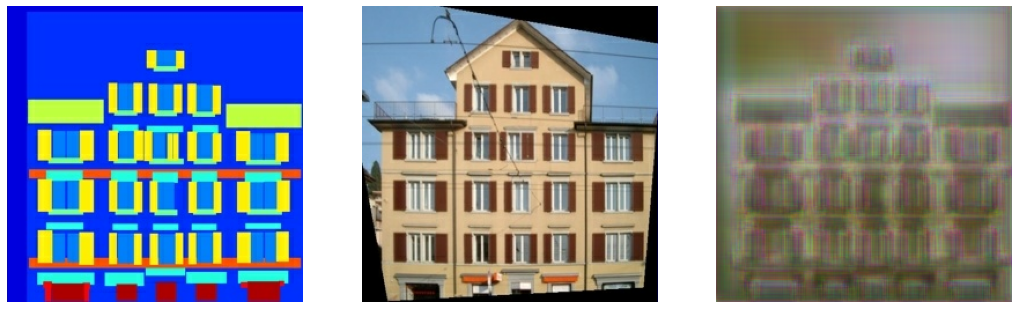

Step 20: discriminator_loss 0.6402 g_loss 34.4938


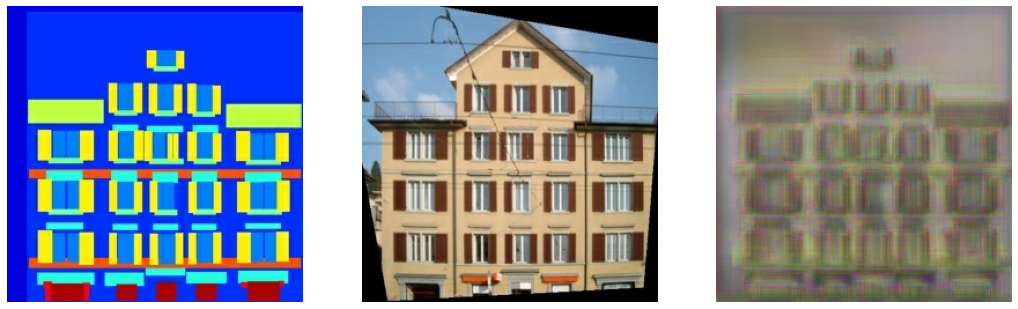

KeyboardInterrupt: 

In [28]:
pix2pix.train(iter(train_dataset), iter(test_dataset), BATCH_SIZE, 20000, 10)

In [29]:
test_iterator = iter(test_dataset)

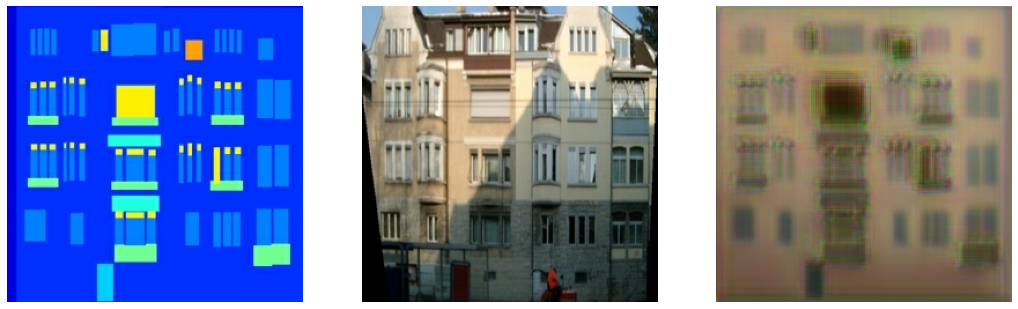

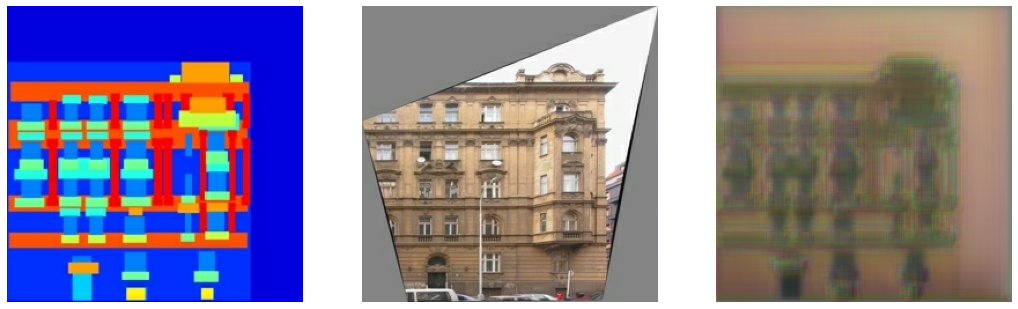

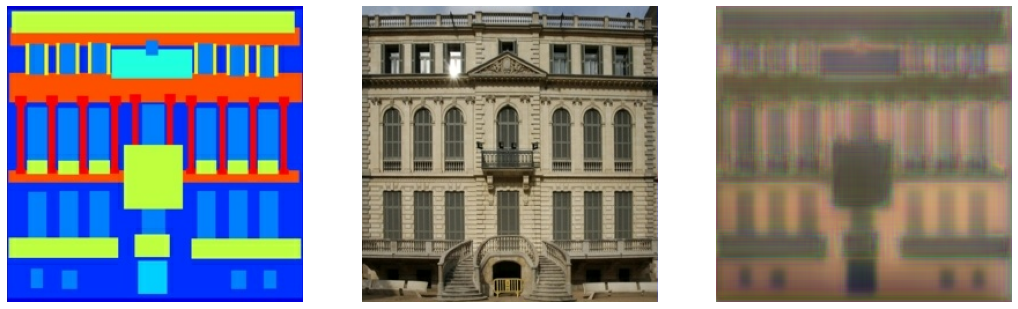

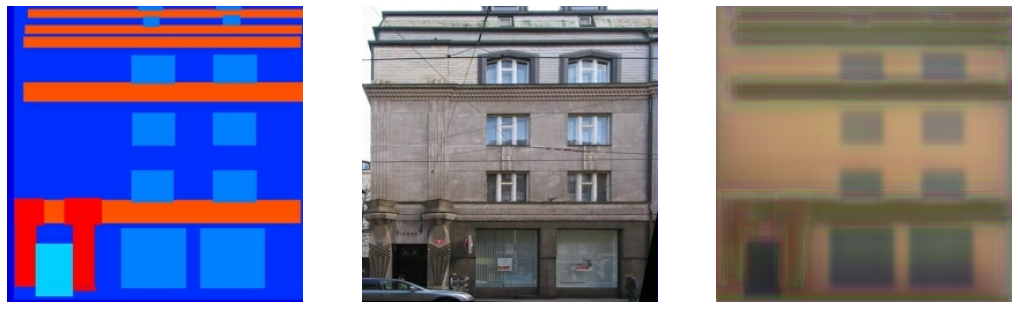

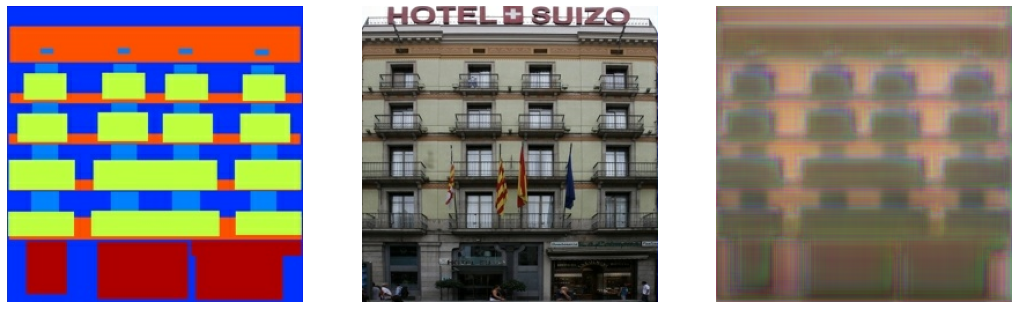

In [30]:
for _ in range(5):
    val_images = next(test_iterator) 
    fake_images = pix2pix.generator.predict(val_images[0])
    pix2pix.plot_images(val_images, fake_images)